In [2]:
import glob
import os
import pickle
import time
import matplotlib.pyplot as plt
import cv2
import numpy as np
import torch
import torch.nn.functional as F
from scripts.gifMaker import color_gif_from_array, make_gif_from_array
from src.common import as_intrinsics_matrix
from torch.utils.data import Dataset
import threading
from tqdm import tqdm
from src.utils.datasets import get_dataset
import time

import torch.multiprocessing as mp
from src.utils import backproject, create_instance_seg, id_generation, vis
import argparse
from src.NICE_SLAM import NICE_SLAM
from src import config
import seaborn as sns

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## render traj

In [3]:
def main():
    parser = argparse.ArgumentParser(
        description="Arguments for running the NICE-SLAM/iMAP*."
    )
    parser.add_argument("config", type=str, help="Path to config file.")
    parser.add_argument("checkpoint", type=str, help="Path to the checkpoint file.")
    parser.add_argument("trajectory", type=str, help="Path to the trajectory file.")
    parser.add_argument(
        "--output",
        type=str,
        help="output folder, this have higher priority, can overwrite the one in config file",
    )
    parser.add_argument(
        "--input_folder",
        type=str,
        help="input folder, this have higher priority, can overwrite the one in config file",
    )
    nice_parser = parser.add_mutually_exclusive_group(required=False)
    nice_parser.add_argument("--nice", dest="nice", action="store_true")
    nice_parser.add_argument("--imap", dest="nice", action="store_false")
    parser.set_defaults(nice=True)

    args = parser.parse_args()
    cfg = config.load_config(  # J:changed it to use our config file including semantics
        args.config, "configs/nice_slam_sem.yaml" if args.nice else "configs/imap.yaml"
    )
    if args.output:
        path = args.output
    else:
        path = None
    slam = NICE_SLAM(cfg, args)
    slam.set_log_dict(args.checkpoint)
    poses = np.loadtxt(args.trajectory)
    poses = poses.reshape(-1, 4, 4)
    # poses = poses[::-1, :, :]
    # poses = poses.copy()
    poses = torch.from_numpy(poses).float()
    render_gif(slam, poses, path)


def render_gif(slam, poses, path=None):
    if path is None:
        path = "run_traj_reversed/"
    else:
        path = path + "/"
    os.makedirs(path, exist_ok=True)
    visualizerForId = vis.visualizerForIds()
    depths, colors, semantics = [], [], []
    for i, c2w in tqdm(enumerate(poses)):
        c2w[:3, 1] *= -1
        c2w[:3, 2] *= -1
        depth, _, color, semantic = slam.vis_renderer.render_img(
            slam.shared_c,
            slam.shared_decoders,
            c2w.to("cuda"),
            "cuda",
            stage="visualize",
            gt_depth=None,
        )
        depth_np = depth.detach().cpu().numpy()
        color_np = color.detach().cpu().numpy()
        color_np = np.clip(color_np, 0, 1)
        semantic_np = semantic.detach().cpu().numpy()
        semantic_argmax = np.argmax(semantic_np, axis=2)
        depths.append(depth_np)
        colors.append(color_np)
        semantics.append(semantic_argmax)
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        ax[0].imshow(color_np)
        ax[1].imshow(depth_np / np.max(depth_np))
        ax[2], _ = visualizerForId.visualize(semantic_argmax, ax=ax[2])
        plt.savefig(f"{path}frame_{i*4}.png")
        plt.close(fig)

    depths = np.stack(depths)
    depths /= np.max(depths)

    color_gif_from_array(colors, "test_color.gif")
    color_gif_from_array(depths, "test_depth.gif")
    make_gif_from_array(semantics, "test_semantic.gif")


if __name__ == "__main__":
    main()

usage: ipykernel_launcher.py [-h] [--output OUTPUT]
                             [--input_folder INPUT_FOLDER] [--nice | --imap]
                             config checkpoint trajectory
ipykernel_launcher.py: error: the following arguments are required: config, checkpoint, trajectory


SystemExit: 2

/home/rozenberszki/anaconda3/envs/wsnsl/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3532: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [7]:
parser = argparse.ArgumentParser(
    description="Arguments for running the NICE-SLAM/iMAP*."
)
parser.add_argument("config", type=str, help="Path to config file.")
parser.add_argument("checkpoint", type=str, help="Path to the checkpoint file.")
parser.add_argument("trajectory", type=str, help="Path to the trajectory file.")
parser.add_argument(
    "--output",
    type=str,
    help="output folder, this have higher priority, can overwrite the one in config file",
)
parser.add_argument(
    "--input_folder",
    type=str,
    help="input folder, this have higher priority, can overwrite the one in config file",
)
nice_parser = parser.add_mutually_exclusive_group(required=False)
nice_parser.add_argument("--nice", dest="nice", action="store_true")
nice_parser.add_argument("--imap", dest="nice", action="store_false")
parser.set_defaults(nice=True)

args = parser.parse_args(args = ["configs/Own/room0_panoptic.yaml","/home/rozenberszki/project/wsnsl/output/Own/room0_panoptic/ckpts/00200.tar","/home/rozenberszki/project/wsnsl/Datasets/Replica/room0_panoptic/traj.txt"])

In [8]:
cfg = config.load_config(  # J:changed it to use our config file including semantics
        args.config, "configs/nice_slam_sem.yaml" if args.nice else "configs/imap.yaml"
    )
slam = NICE_SLAM(cfg, args)

INFO: The output folder is output/Own/room0_panoptic
INFO: The GT, generated and residual depth/color images can be found under output/Own/room0_panoptic/mapping_vis/
INFO: The mesh can be found under output/Own/room0_panoptic/mesh/
INFO: The checkpoint can be found under output/Own/room0_panoptic/ckpt/


In [10]:
slam.set_log_dict("/home/rozenberszki/project/wsnsl/output/Own/room0_panoptic/ckpts/00200.tar", map_location='cuda')

In [11]:
slam.frame_reader.poses

[tensor([[-0.3901, -0.0472, -0.9196,  1.8004],
         [-0.9208,  0.0200,  0.3896,  2.1238],
         [-0.0000,  0.9987, -0.0512, -0.4439],
         [ 0.0000,  0.0000,  0.0000,  1.0000]]),
 tensor([[-0.3951, -0.0372, -0.9179,  1.7828],
         [-0.9186,  0.0160,  0.3948,  2.1309],
         [-0.0000,  0.9992, -0.0405, -0.4410],
         [ 0.0000,  0.0000,  0.0000,  1.0000]]),
 tensor([[-0.3989, -0.0274, -0.9166,  1.7646],
         [-0.9170,  0.0119,  0.3988,  2.1367],
         [-0.0000,  0.9996, -0.0299, -0.4375],
         [ 0.0000,  0.0000,  0.0000,  1.0000]]),
 tensor([[-0.4031, -0.0083, -0.9151,  1.7261],
         [-0.9152,  0.0036,  0.4031,  2.1445],
         [-0.0000,  1.0000, -0.0090, -0.4287],
         [ 0.0000,  0.0000,  0.0000,  1.0000]]),
 tensor([[-4.0352e-01,  9.9948e-04, -9.1497e-01,  1.7060e+00],
         [-9.1497e-01, -4.4079e-04,  4.0352e-01,  2.1466e+00],
         [-0.0000e+00,  1.0000e+00,  1.0924e-03, -4.2345e-01],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1

In [20]:
path = "/home/rozenberszki/project/wsnsl/Datasets/Replica/room0_panoptic/test_results_org_pan"
depths = sorted(glob.glob(path + '/depth*'))
depth_path = depths[10]
depth_data = cv2.imread(depth_path, cv2.IMREAD_UNCHANGED)
depth_data = depth_data.astype(np.float32) / slam.frame_reader.png_depth_scale
depth_data = torch.from_numpy(depth_data)
depth_data = depth_data.to('cuda')

In [28]:
depth, uncertainty, color, semantic = slam.vis_renderer.render_img( #Done add semantics
                    slam.shared_c,
                    slam.shared_decoders,
                    slam.frame_reader.poses[10].to('cuda'),
                    'cuda',
                    stage='visualize',
                    gt_depth=None)

Parameters (480, 640, 320.0, 320.0, 319.5, 239.5, tensor([[-0.3759,  0.0668, -0.9243,  1.5290],
        [-0.9267, -0.0271,  0.3749,  2.1232],
        [-0.0000,  0.9974,  0.0721, -0.3650],
        [ 0.0000,  0.0000,  0.0000,  1.0000]], device='cuda:0'))


In [29]:
from src.utils import vis
visualizerForIds = vis.visualizerForIds()

In [30]:
depth_np = depth.detach().cpu().numpy()
color_np = color.detach().cpu().numpy()
semantic_np = semantic.detach().cpu().numpy()

In [31]:
max_depth = np.max(depth_np)

In [32]:
color_np.shape

(480, 640, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


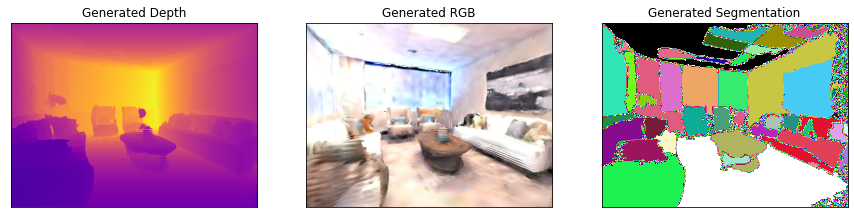

In [33]:
fig, axs = plt.subplots(1,3, figsize=(15,5))

axs[0].imshow(depth_np, cmap="plasma",
                vmin=0, vmax=max_depth)
axs[0].set_title('Generated Depth')
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[1].imshow(color_np, cmap="plasma")
axs[1].set_title('Generated RGB')
axs[1].set_xticks([])
axs[1].set_yticks([])
#------------------added------------------
semantic_argmax = np.argmax(semantic_np, axis=2)
axs[2], im = visualizerForIds.visualize(semantic_argmax, ax=axs[2], title='Generated Segmentation')
axs[2].set_xticks([])
axs[2].set_yticks([])
plt.show()


In [9]:
from tqdm import tqdm

In [10]:
poses = slam.frame_reader.poses[:60]
poses

[tensor([[-3.2057e-01, -4.4806e-01,  8.3455e-01,  3.4530e+00],
         [ 9.4722e-01, -1.5164e-01,  2.8244e-01,  4.5461e-01],
         [ 1.0790e-16,  8.8105e-01,  4.7302e-01,  5.9363e-01],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]]),
 tensor([[-3.1393e-01, -4.5307e-01,  8.3437e-01,  3.4572e+00],
         [ 9.4945e-01, -1.4981e-01,  2.7588e-01,  4.6971e-01],
         [ 1.0762e-16,  8.7880e-01,  4.7719e-01,  5.9427e-01],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]]),
 tensor([[-3.0848e-01, -4.5677e-01,  8.3439e-01,  3.4614e+00],
         [ 9.5123e-01, -1.4812e-01,  2.7058e-01,  4.8419e-01],
         [ 1.0742e-16,  8.7717e-01,  4.8018e-01,  5.9430e-01],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]]),
 tensor([[-3.0417e-01, -4.5922e-01,  8.3463e-01,  3.4657e+00],
         [ 9.5262e-01, -1.4663e-01,  2.6649e-01,  4.9806e-01],
         [ 1.0730e-16,  8.7614e-01,  4.8206e-01,  5.9373e-01],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00, 

In [11]:
depths, colors, semantics = [], [], []
for c2w in tqdm(poses[::20]):
    depth, _ , color, semantic = slam.renderer.render_img(
        slam.shared_c,
        slam.shared_decoders,
        c2w.to('cuda'),
        'cuda',
        stage='visualize',
        gt_depth=None
    )
    depth_np = depth.detach().cpu().numpy()
    color_np = color.detach().cpu().numpy()
    semantic_np = semantic.detach().cpu().numpy()
    semantic_argmax = np.argmax(semantic_np, axis=2)
    depths.append(depth_np)
    colors.append(color_np)
    semantics.append(semantic_argmax)

100%|██████████| 3/3 [00:03<00:00,  1.07s/it]


In [12]:
depths = np.stack(depths)
depths /= np.max(depths)

In [13]:
color_gif_from_array(colors, 'test_color.gif')
color_gif_from_array(depths, 'test_depth.gif')
make_gif_from_array(semantics, 'test_semantic.gif')

## vis traj movement

In [12]:
path = '/home/rozenberszki/project/wsnsl/Datasets/Replica/room0_panoptic/traj.txt'

In [13]:
traj = np.loadtxt(path)
traj = traj.reshape(-1, 4, 4)
traj.shape

(675, 4, 4)

: 

In [7]:
x = traj[:, 0, 3]
y = traj[:, 1, 3]
z = traj[:, 2, 3]

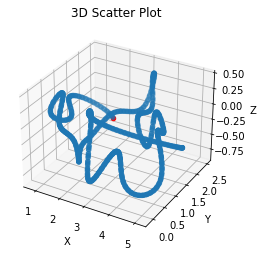

In [10]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


# Create a figure and a 3D axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the data
ax.scatter(x[0], y[0], z[0], c='r', marker='o', label='Start')
ax.scatter(x, y, z)

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Scatter Plot')

# Show the plot
plt.show()
